In [48]:
#imports
from fastai.vision.all import *
from fastdownload import download_url
from duckduckgo_search import ddg_images
from fastai.vision.widgets import *
from fastcore.all import *
from time import sleep
from PIL import Image

In [49]:
#Creating a search function 
def search_images(term,max_images=30):
    print(f"searching for {term}")
    return L(ddg_images(term,max_results=max_images)).itemgot('image')


#L is a type of list item that is used by fast ai

In [50]:
emotion_types = ['happy','sad','angry','fear']
path = Path('emotions')


In [51]:
#Making directory
if not path.exists():
    for o in emotion_types:
        dest = (path/o)
        dest.mkdir(exist_ok= True,parents=True)
        results = search_images(f'{o} human face')
        download_images(dest,urls=results)
        
        

searching for happy human face
searching for sad human face
searching for angry human face
searching for fear human face


In [52]:
#Removing failed photos
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

In [59]:
emos = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    #independent and dependent variable outputs
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label,
    item_tfms = Resize(128)
)

In [60]:
dls = emos.dataloaders(path)

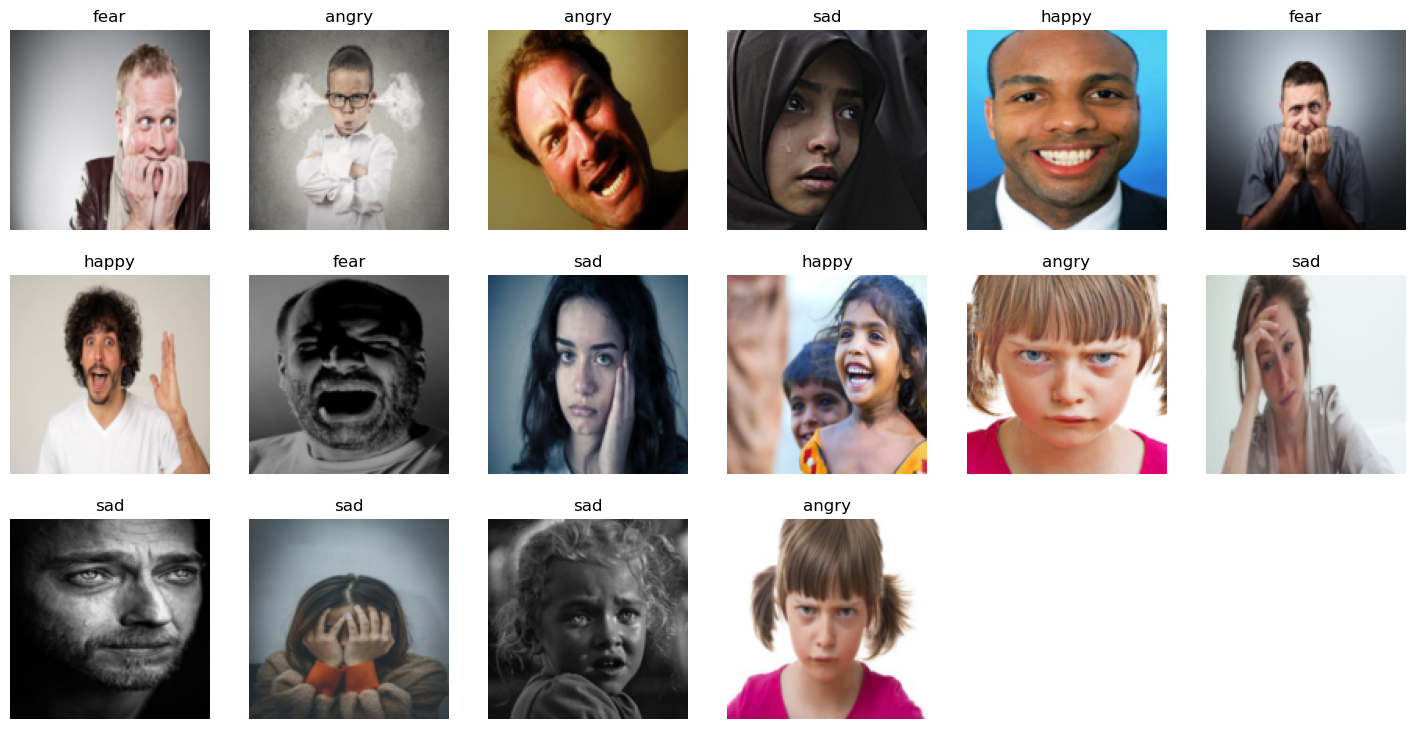

In [61]:
dls.valid.show_batch(max_n=16,nrows=3)

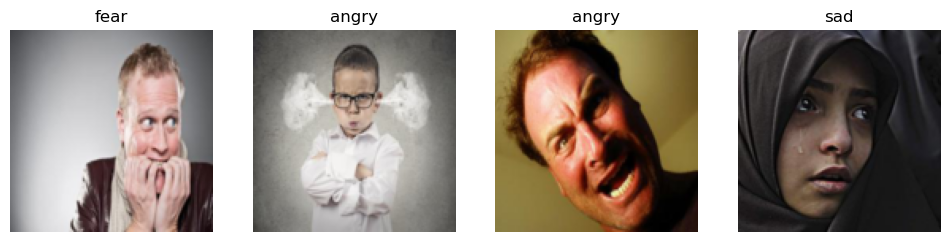

In [62]:
emos = emos.new(item_tfms=Resize(128,ResizeMethod.Squish))
dls = emos.dataloaders(path)
dls.valid.show_batch(max_n=4,nrows=1)

 The mult=2 argument specifies that the number of augmentations applied to each image in a batch will be multiplied by 2.

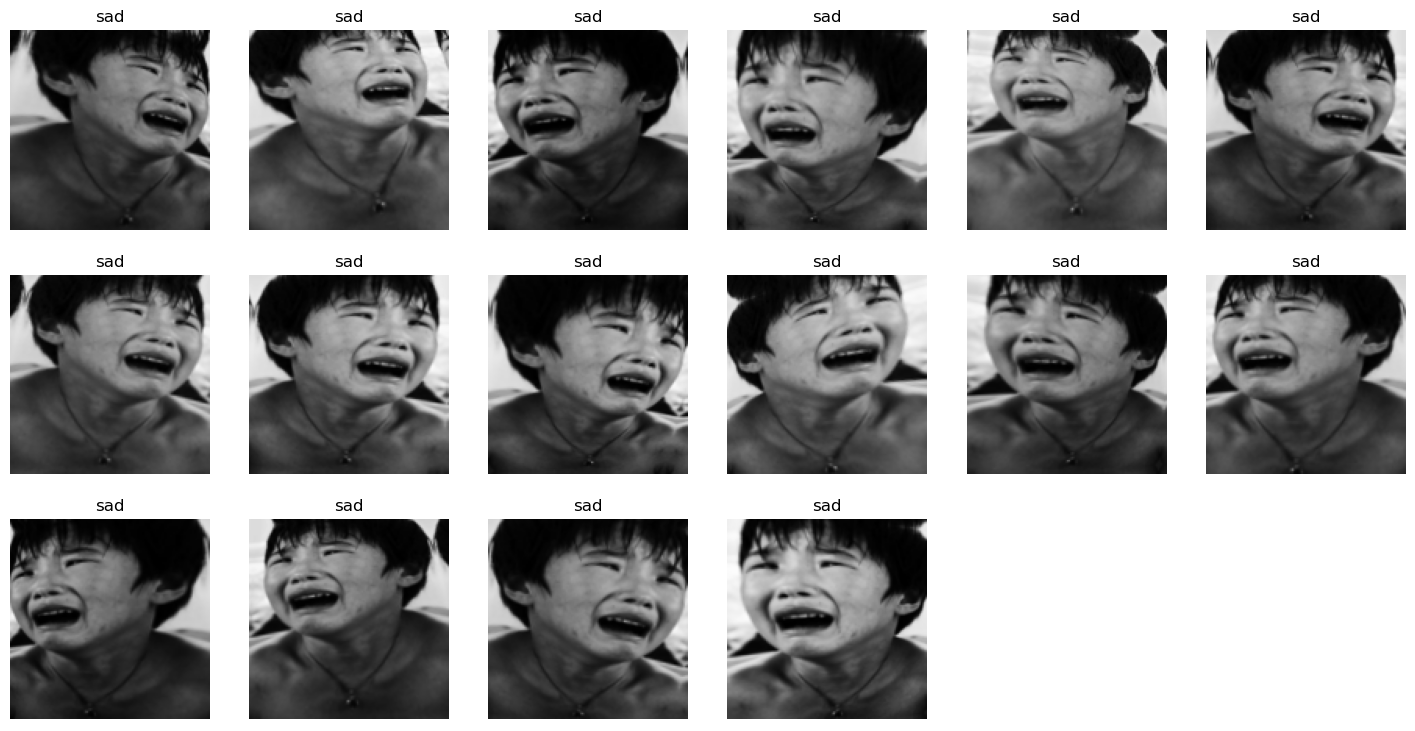

In [63]:
#Using Data Augmentation
#batch_tfms are used during Data augmentation
emos = emos.new(item_tfms=Resize(128),batch_tfms=aug_transforms())
dls = emos.dataloaders(path)
dls.train.show_batch(max_n=16,nrows=3,unique=True)

In [64]:
emos = emos.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = emos.dataloaders(path)

In [65]:
#Creating the cnn model with resnet 18
learn = vision_learner(dls,resnet18,metrics=error_rate)
learn.fine_tune(10)

/home/pranavajay/miniconda3/envs/pytorchEnv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pranavajay/miniconda3/envs/pytorchEnv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.235671,2.625914,0.695652,00:01


epoch,train_loss,valid_loss,error_rate,time
0,2.660741,2.233916,0.652174,00:01
1,2.311252,1.923520,0.565217,00:01
2,2.229796,1.649765,0.521739,00:01
3,2.154191,1.401487,0.434783,00:01
4,1.970650,1.338490,0.391304,00:01
5,1.868801,1.361462,0.478261,00:01
6,1.718626,1.373721,0.478261,00:01
7,1.569964,1.352926,0.478261,00:01
8,1.490439,1.323745,0.478261,00:01
9,1.429725,1.301138,0.478261,00:01


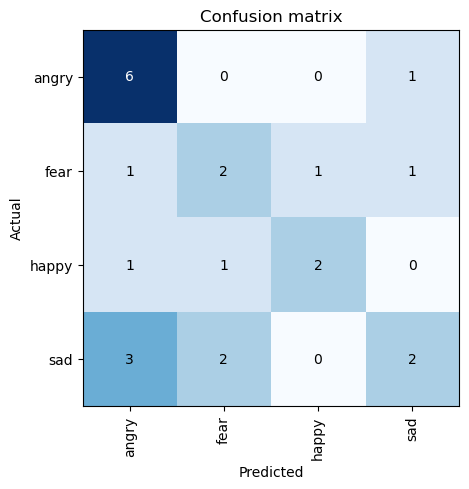

In [66]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

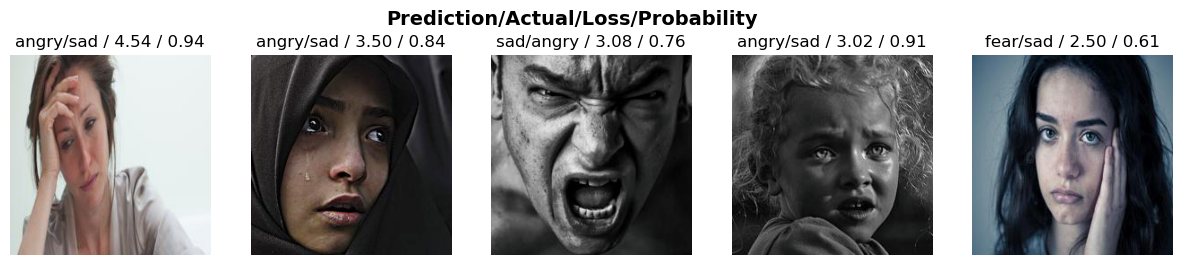

In [67]:
interp.plot_top_losses(5, nrows=1)

In [72]:
#Cleaning images - note here cleaning after training
cleaner = ImageClassifierCleaner(learn)
cleaner


In [25]:
#Deleting the selected images
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [ ]:
#Changing the category
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [74]:
learn.predict('examples/happy.jpeg')

('happy', tensor(2), tensor([0.3468, 0.0121, 0.6246, 0.0166]))

In [75]:
learn.export()